In [ ]:
!pip install nltk
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=23b154f334e01152659d4802b803d48bdab6c29a9b737a333dca1f1583ec9da9
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from gensim import corpora, models
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


In [ ]:

# Load the dataset
df = pd.read_csv("/content/sample_data/depression_2019_features_tfidf_256_clean.csv", error_bad_lines=False)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

<ipython-input-24-4f8831eb389b>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("/content/sample_data/depression_2019_features_tfidf_256_clean.csv", error_bad_lines=False)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Preprocess the text
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
   
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the text

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Convert tokens back to text
    processed_text = ' '.join(tokens)
    return processed_text

df['processed_text'] = df['post'].apply(preprocess_text)



In [ ]:
# Generate embeddings using S-BERT
model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = model.encode(df['processed_text'])

In [ ]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
labels = kmeans.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# #Apply dimensionality reduction using LSA
# lsa = TruncatedSVD(n_components=10, random_state=42)
# lsa_features = lsa.fit_transform(embeddings)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2)
X = vectorizer.fit_transform(df['post'])
svd = TruncatedSVD(n_components=num_clusters)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)

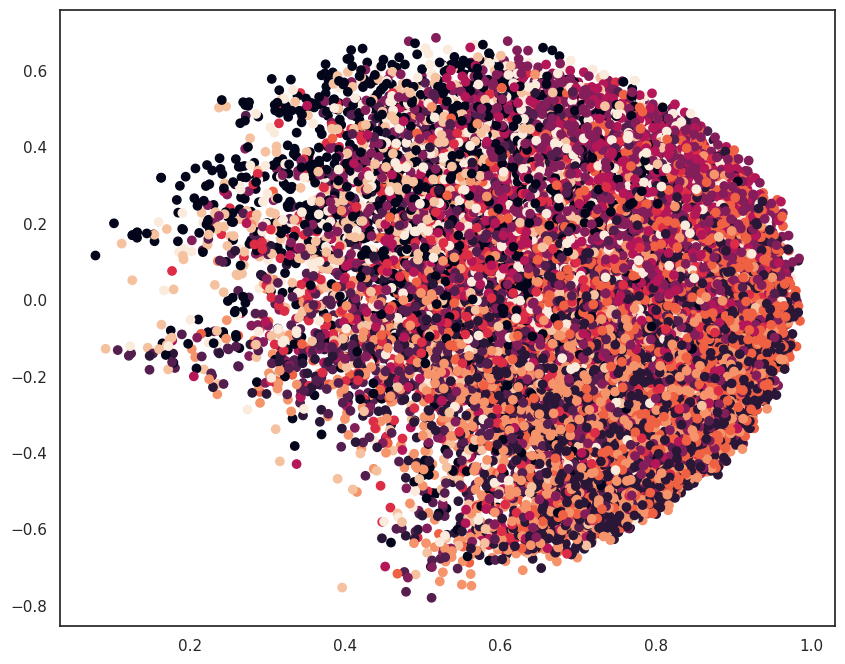

In [ ]:
# Visualize the clusters using a scatter plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=labels)
plt.show()

In [ ]:
# Calculate correlation matrix
corr_matrix = np.corrcoef(X_lsa.T)
# Print the correlation matrix
print(corr_matrix)

[[ 1.00000000e+00 -1.59314258e-01 -3.21281170e-01  4.53116244e-02
   1.85260683e-02 -9.80839085e-02 -5.91900965e-02 -8.08161232e-02
  -2.46659517e-01  4.37614628e-03]
 [-1.59314258e-01  1.00000000e+00  6.67089146e-02 -7.63659085e-02
   6.26446957e-02 -2.22849052e-02 -4.68419169e-02  5.55831421e-04
  -2.82570772e-02 -1.13781435e-02]
 [-3.21281170e-01  6.67089146e-02  1.00000000e+00  1.81668375e-01
  -1.19768791e-01 -5.14765770e-02 -2.77825603e-02 -7.94802334e-02
  -2.35788175e-03 -4.25309424e-02]
 [ 4.53116244e-02 -7.63659085e-02  1.81668375e-01  1.00000000e+00
  -1.34205378e-02  1.82910751e-02 -2.37262934e-02 -5.98752215e-03
   5.09184510e-02  1.71912543e-02]
 [ 1.85260683e-02  6.26446957e-02 -1.19768791e-01 -1.34205378e-02
   1.00000000e+00  1.27588280e-02 -3.37752040e-02 -5.17929914e-02
   1.68361693e-02  8.57697764e-03]
 [-9.80839085e-02 -2.22849052e-02 -5.14765770e-02  1.82910751e-02
   1.27588280e-02  1.00000000e+00  2.78651242e-02  1.97423710e-03
   5.99775115e-02  4.40777614e-03

In [ ]:
# Convert LSA features to a dataframe
df_lsa = pd.DataFrame(X_lsa, columns=['lsa_feature_' + str(i+1) for i in range(X_lsa.shape[1])])

# Merge LSA features with original dataframe
df = pd.concat([df, df_lsa], axis=1)

# Extract topic labels using LDA
dictionary = corpora.Dictionary(df['processed_text'].apply(nltk.word_tokenize))
corpus = [dictionary.doc2bow(text) for text in df['processed_text'].apply(nltk.word_tokenize)]
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)
df['topic_labels'] = [lda_model.get_document_topics(corpus[i])[0][0] for i in range(len(corpus))]

# Calculate correlation between topics using Pearson correlation coefficient
topic_correlations = []
for i in range(10):
    topic_embeddings = embeddings[df['topic_labels'] == i]
    topic_lsa_features = X_lsa[df['topic_labels'] == i]
    if len(topic_embeddings) > 1:
        corr_matrix = np.corrcoef(topic_lsa_features.T)
        topic_correlations.append((i, np.mean(corr_matrix)))

# Print the average correlation for each topic
for correlation in topic_correlations:
    print('Topic', correlation[0], 'correlation:', correlation[1])

Topic 0 correlation: 0.07992072271039917
Topic 1 correlation: 0.08309802464085016
Topic 2 correlation: 0.07845534683225544
Topic 3 correlation: 0.08744026162700252
Topic 4 correlation: 0.0833713354473991
Topic 5 correlation: 0.07582764591451086
Topic 7 correlation: 0.058464604553481875
Topic 8 correlation: 0.04656822256436866


In [ ]:
#List of topics 
top_words = []
for i in range(10):
    print(f'Topic {i}:')
    top_words = lda_model.show_topic(i, topn=10)
    for word, prob in top_words:
        print(f'{word}: {prob:.3f}')
    print('\n')


Topic 0:
friend: 0.049
people: 0.040
talk: 0.019
one: 0.016
someone: 0.014
social: 0.012
really: 0.010
help: 0.009
game: 0.009
post: 0.008


Topic 1:
job: 0.024
get: 0.019
work: 0.019
life: 0.015
year: 0.015
school: 0.013
feel: 0.012
like: 0.012
time: 0.011
go: 0.011


Topic 2:
depression: 0.046
help: 0.031
anxiety: 0.018
medication: 0.016
ha: 0.015
doctor: 0.015
therapy: 0.014
mental: 0.013
therapist: 0.013
med: 0.012


Topic 3:
wa: 0.060
year: 0.017
amp: 0.014
time: 0.014
x200b: 0.011
day: 0.010
month: 0.010
back: 0.010
got: 0.010
last: 0.009


Topic 4:
feel: 0.050
like: 0.040
know: 0.024
want: 0.019
really: 0.014
feeling: 0.013
get: 0.013
even: 0.012
time: 0.012
thing: 0.011


Topic 5:
life: 0.030
want: 0.029
fucking: 0.019
hate: 0.017
people: 0.014
die: 0.012
shit: 0.012
na: 0.012
one: 0.011
even: 0.011


Topic 6:
woman: 0.065
girl: 0.063
sex: 0.060
date: 0.027
sexual: 0.021
attractive: 0.017
men: 0.017
dating: 0.014
porn: 0.012
ugly: 0.011


Topic 7:
day: 0.016
get: 0.010
thing: 0

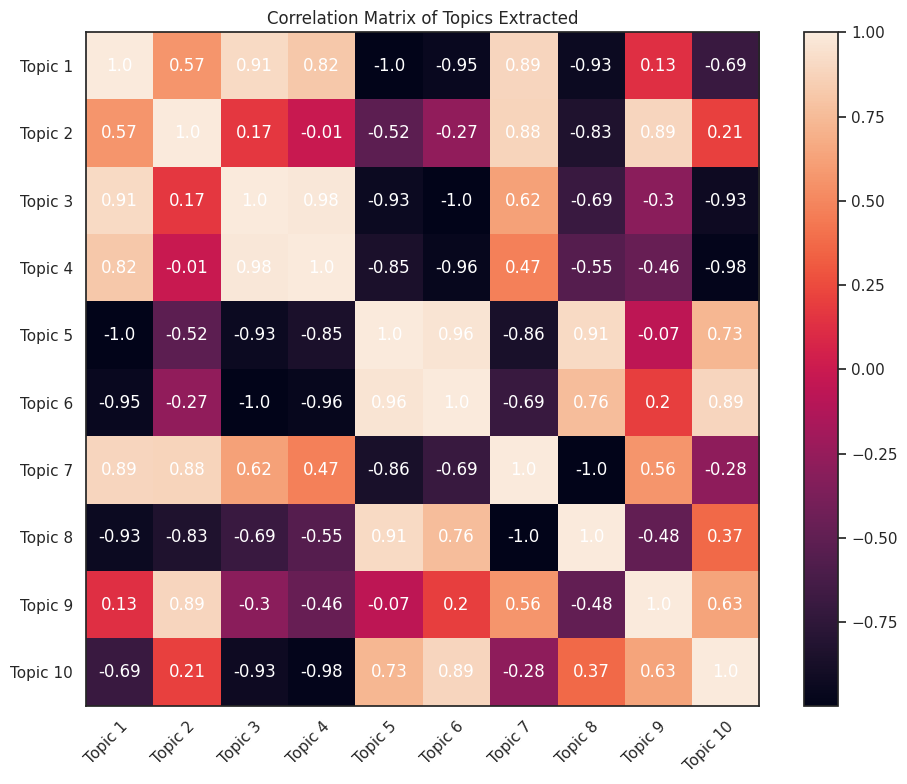

In [ ]:
# Visualize correlation matrix
topic_names = ['Topic ' + str(i+1) for i in range(lda_model.num_topics)]
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels and rotation
ax.set_xticks(np.arange(len(topic_names)))
ax.set_yticks(np.arange(len(topic_names)))
ax.set_xticklabels(topic_names)
ax.set_yticklabels(topic_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data and create annotations
for i in range(len(topic_names)):
    for j in range(len(topic_names)):
        text = ax.text(j, i, round(corr_matrix[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Correlation Matrix of Topics Extracted")
fig.tight_layout()
plt.show()

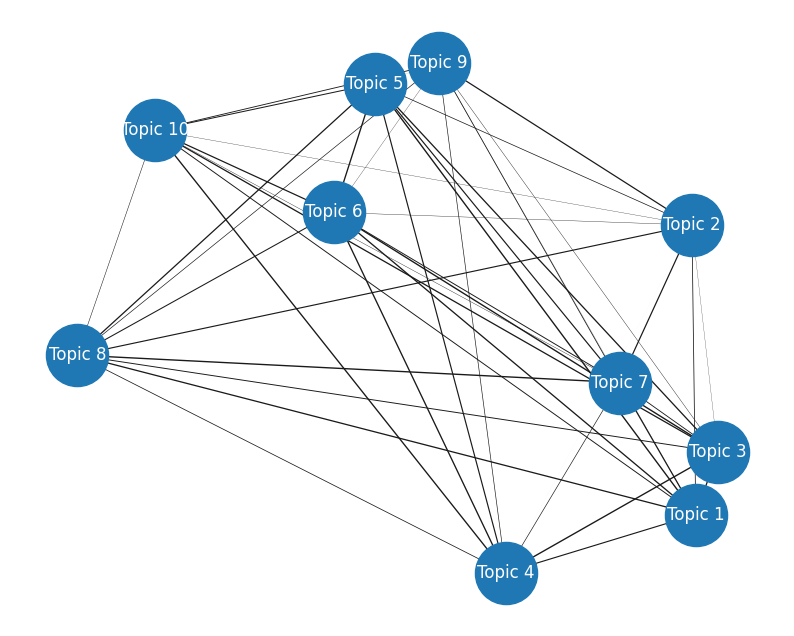

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add nodes for each topic
for i, topic in enumerate(topic_names):
    G.add_node(topic)

# Add edges between topics with correlation above a threshold
for i in range(len(topic_names)):
    for j in range(i+1, len(topic_names)):
        # if corr_matrix[i][j] > threshold:
          G.add_edge(topic_names[i], topic_names[j], weight=corr_matrix[i][j])

# Draw the graph
pos = nx.spring_layout(G, k=0.5)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', font_color='white')
plt.axis('off')
plt.show()
